---

# Automatic Feature Selection

By: Tomás Urdiales

-> Notebook for early experiments with automatic feature selection using: trees, Boruta, SHAP.

##### Libraries

In [ ]:
# Change notebook CWD to the project's root, so python can read from src:
import os
os.chdir("..")

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE

from src import utils
from src.join_qh_min_data import join_qh_min_data
from src.cross_validation import backtesting_CV

##### Parameters

In [2]:
CWD = utils.get_root_dir()

# To not use darts plotting style:
plt.style.use('default')

DPI = 150 # (pixel density for figures)
ELIA_ORANGE = (250/256, 115/256, 1/256) # RGB

##### Load data

In [3]:
qh = utils.load_qh_historical_data().loc["2021":"2022"]
minute = utils.load_min_historical_data().loc["2021":"2022"]
ems = utils.load_ems_historical_data().loc["2021":"2022"]
xb = utils.load_xb_historical_data().loc["2021":"2022"]

# Additional features:
ems.insert(1, "elia_sum_prod_mw_cm-value-diff", ems["elia_sum_prod_mw_cm-value"].diff())
minute["rolling_15"] = minute["system_imbalance"].rolling(window=15, center=False).mean()
minute["rolling_60"] = minute["system_imbalance"].rolling(window=60, center=False).mean()

---

## Random Forest Regressor

#### Lags of system_imbalance_cum15

In [4]:
MINUTE = 3

lags = [-x for x in range(-1, 50)]
lags.remove(0)
lags.extend([1-4*24, 1-4*24+1, 1-4*24-1, 1-4*24*7, 1-4*24*7+1, 1-4*24*7-1])

qh_parameters = {
    "system_imbalance_cum15": {
        "lags": lags},
}

# Prepare training dataframe:
df = join_qh_min_data(
    qh_data=qh,
    qh_parameters=qh_parameters,
    minute_data=None,
    minute_parameters=None,
    minute=MINUTE,
)
TARGET = "system_imbalance_cum15_from_qh_plus_1"
FEATURES = [feature for feature in df.columns if feature != TARGET]

df = df.dropna()

In [5]:
# Fit a Random Forest regressor model:
selector = RandomForestRegressor(
    n_estimators=250,
    max_depth=7,
    criterion="squared_error",
    n_jobs=-1,
    verbose=True)

selector.fit(df[FEATURES], df[TARGET])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   55.0s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  1.3min finished


RandomForestRegressor(max_depth=7, n_estimators=250, n_jobs=-1, verbose=True)

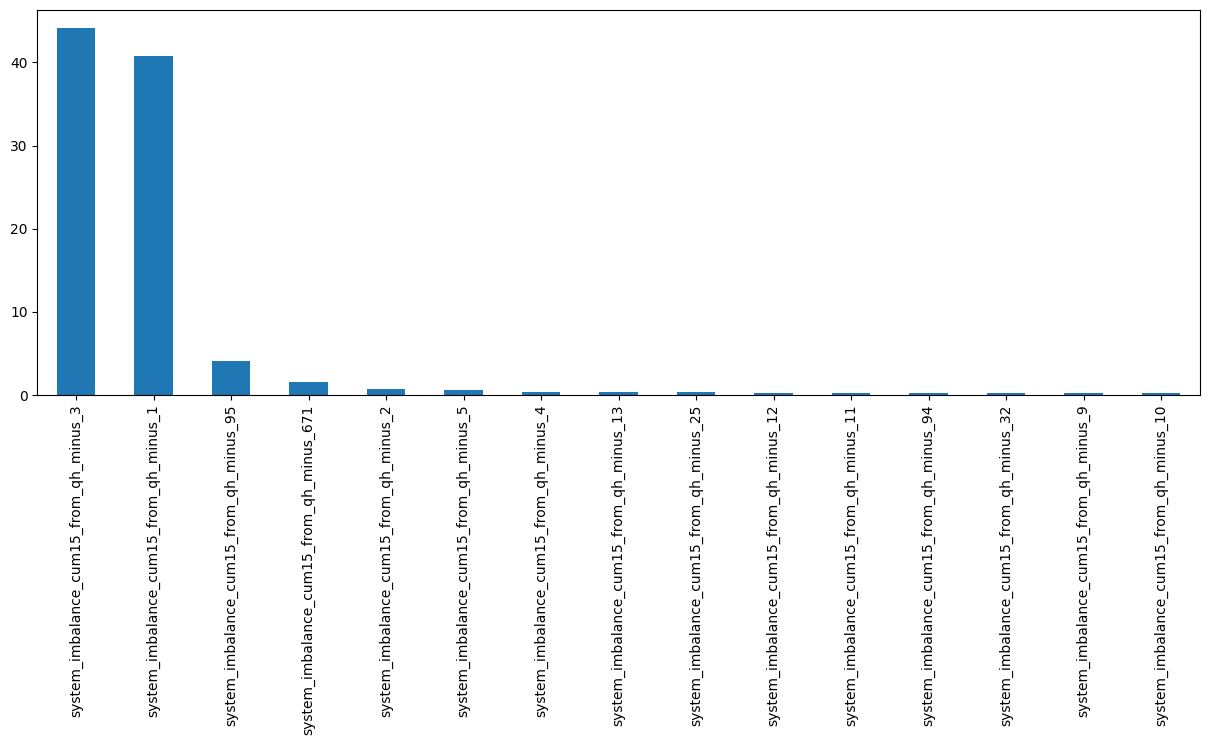

In [6]:
feature_importance = pd.DataFrame(data={"importance": 100*selector.feature_importances_}, index=FEATURES)

# Plot importance scores:
# fig, ax = plt.subplots(figsize=[15,5])
feature_importance.importance.nlargest(15).plot(kind="bar")
# ax.bar([ii for ii in range(len(FEATURES))], to_show)
# plt.xticks([ii for ii in range(len(FEATURES))], FEATURES)
plt.show()

#### Lags of minute system_imbalance 

In [24]:
MINUTE = 3

qh_parameters = {
    "system_imbalance_cum15": {
        "lags": [1]},
}

lags = [-x for x in range(0, 65)]
lags.remove(0)
lags.extend([-60*2, -60*2+1, -60*2-1, -60*3, -60*3+1, -60*3-1, -60*24, -60*24+1, -60*24-1])

minute_parameters = {
    "system_imbalance": {
        "lags": lags},
}

# Prepare training dataframe:
df = join_qh_min_data(
    qh_data=qh,
    qh_parameters=qh_parameters,
    minute_data=minute,
    minute_parameters=minute_parameters,
    minute=MINUTE,
)
TARGET = "system_imbalance_cum15_from_qh_plus_1"
FEATURES = [feature for feature in df.columns if feature != TARGET]

df = df.dropna()

In [26]:
# Fit a Random Forest regressor model:
selector = RandomForestRegressor(
    n_estimators=250,
    max_depth=7,
    criterion="squared_error",
    n_jobs=-1,
    verbose=True)

selector.fit(df[FEATURES], df[TARGET])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  1.6min finished


RandomForestRegressor(max_depth=7, n_estimators=250, n_jobs=-1, verbose=True)

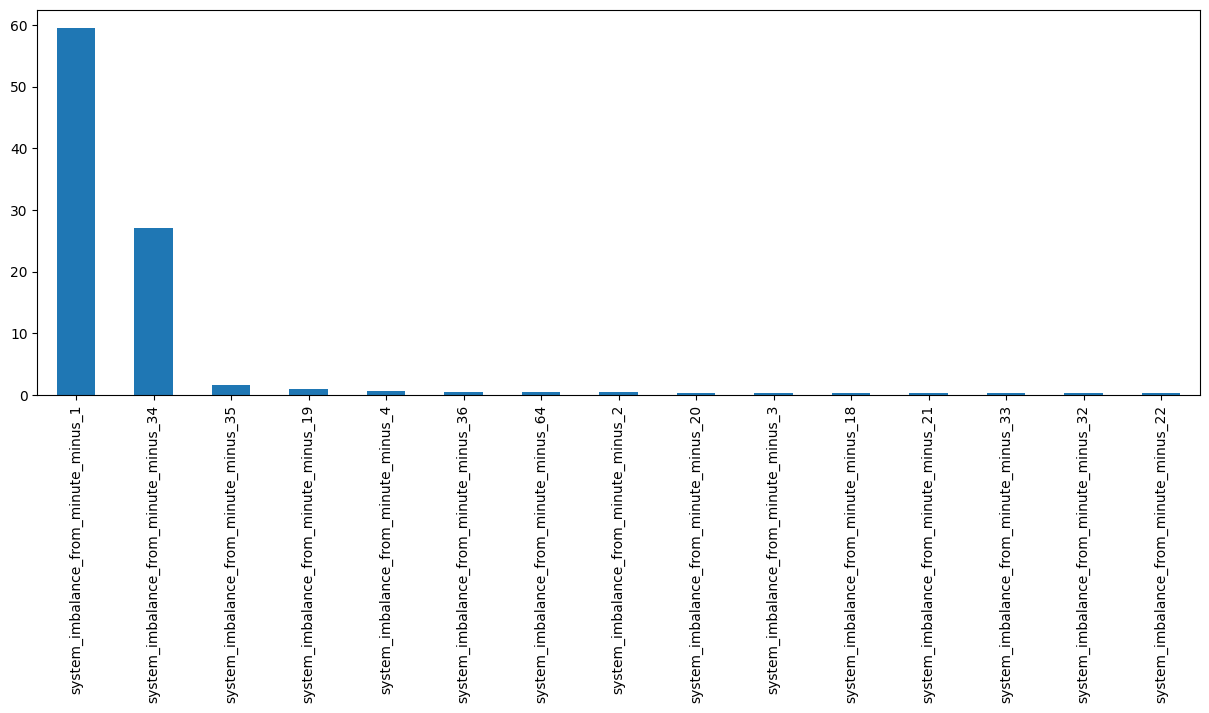

In [27]:
feature_importance = pd.DataFrame(data={"importance": 100*selector.feature_importances_}, index=FEATURES)

# Plot importance scores:
fig, ax = plt.subplots(figsize=[15, 5])
feature_importance.importance.nlargest(15).plot(kind="bar")
# ax.bar([ii for ii in range(len(FEATURES))], to_show)
# plt.xticks([ii for ii in range(len(FEATURES))], FEATURES)
plt.show()

#### Exogenous (qh) variables

In [32]:
MINUTE = 3

qh_parameters = {
    "system_imbalance_cum15": {
        "lags": [1]},
    "total_load_last_mw": {
        "lags": [4, 3, 2, 1, 0, -1, -2, -3, -4]},
    "total_load_forecast_last_p10_mw": {
        "lags": [4, 3, 2, 1, 0, -1, -2, -3, -4]},
    "total_load_forecast_last_p90_mw": {
        "lags": [4, 3, 2, 1, 0, -1, -2, -3, -4]},
    "wind_id_mw": {
        "lags":[4, 3, 2, 1, 0, -1, -2, -3, -4]},
    "wind_production_forecast_intraday_p10_mw": {
        "lags":[4, 3, 2, 1, 0, -1, -2, -3, -4]},
    "wind_production_forecast_intraday_p90_mw": {
        "lags":[4, 3, 2, 1, 0, -1, -2, -3, -4]},

    "load_rt_mw": {
        "lags": [-1, -2, -3, -4]},
    "wind_rt_mw": {
        "lags": [-1, -2, -3, -4]},
}

df = join_qh_min_data(
    qh_data=qh,
    qh_parameters=qh_parameters,
    minute=MINUTE,
)
TARGET = "system_imbalance_cum15_from_qh_plus_1"
FEATURES = [feature for feature in df.columns if feature != TARGET]

df = df.dropna()

# Fit a Random Forest regressor model:
selector = RandomForestRegressor(
    n_estimators=250,
    max_depth=7,
    criterion="squared_error",
    n_jobs=-1,
    verbose=True)

selector.fit(df[FEATURES], df[TARGET])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   53.8s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  1.2min finished


RandomForestRegressor(max_depth=7, n_estimators=250, n_jobs=-1, verbose=True)

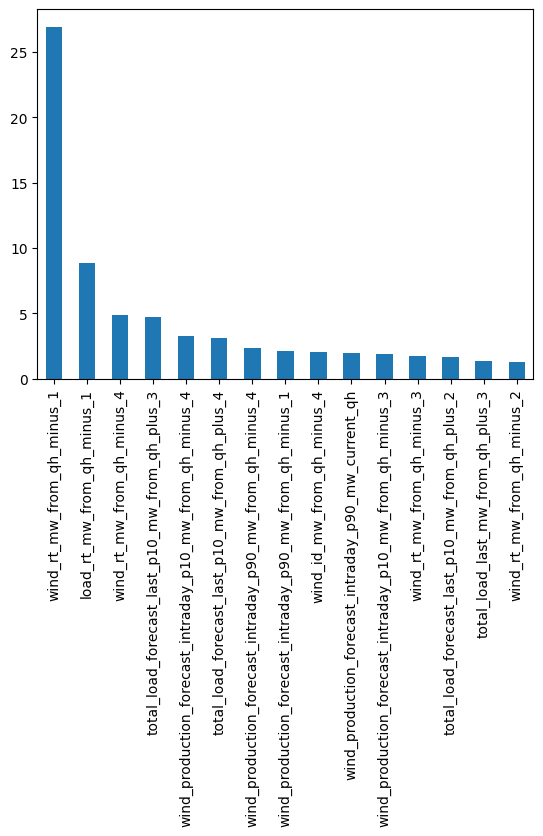

In [20]:
feature_importance = pd.DataFrame(data={"importance": 100*selector.feature_importances_}, index=FEATURES)

# Plot importance scores:
# fig, ax = plt.subplots(figsize=[15, 5])
feature_importance.importance.nlargest(15).plot(kind="bar")
plt.show()

In [39]:
MINUTE = 3

qh_parameters = {
    "system_imbalance_cum15": {
        "lags": [1, -1, -2, -3, -5, -95, -671]},

    "total_load_last_mw": {
        "lags": [3, 2, 1, 0, -1, -2, -3, -4]},

    "nrv_rt": {
        "lags": [-1, -2, -3, -4]},
    "load_rt_mw": {
        "lags": [-1, -2, -3, -4]},
    "wind_rt_mw": {
        "lags": [-1, -2, -3, -4]},

    # "total_load_forecast_last_p10_mw": {
    #     "lags": [-4]},
    # "total_load_forecast_last_p90_mw": {
    #     "lags": [-4]},
}


minute_parameters = {
    "system_imbalance": {
        "lags": [0, -1, -4]},
    "net_regulation_volume": {
        "lags": [0, -1, -2, -3]},
}

# Prepare training dataframe:
df = join_qh_min_data(
    qh_data=qh,
    minute_data=minute,
    qh_parameters=qh_parameters,
    minute_parameters=minute_parameters,
    minute=MINUTE,
    # ems_data=ems,
    # ems_parameters=ems_parameters,
)
TARGET = "system_imbalance_cum15_from_qh_plus_1"
FEATURES = [feature for feature in df.columns if feature != TARGET]

df = df.dropna()

# Fit a Random Forest regressor model:
selector = RandomForestRegressor(
    n_estimators=250,
    max_depth=7,
    criterion="squared_error",
    n_jobs=-1,
    verbose=True)

selector.fit(df[FEATURES], df[TARGET])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   41.6s finished


RandomForestRegressor(max_depth=7, n_estimators=250, n_jobs=-1, verbose=True)

#### More exogenous (qh) variables

In [4]:
MINUTE = 3

qh_parameters = {
    "system_imbalance_cum15": {
        "lags": [1]},
    "total_load_last_mw": {
        "lags": [4, 3, 2, 1, 0, -1, -2, -3, -4]},
    "total_load_forecast_last_p10_mw": {
        "lags": [4, 3, 2, 1, 0, -1, -2, -3, -4]},
    "total_load_forecast_last_p90_mw": {
        "lags": [4, 3, 2, 1, 0, -1, -2, -3, -4]},
    "wind_id_mw": {
        "lags":[4, 3, 2, 1, 0, -1, -2, -3, -4]},
    "wind_production_forecast_intraday_p10_mw": {
        "lags":[4, 3, 2, 1, 0, -1, -2, -3, -4]},
    "wind_production_forecast_intraday_p90_mw": {
        "lags":[4, 3, 2, 1, 0, -1, -2, -3, -4]},
    "solar_id_mw": {
        "lags":[4, 3, 2, 1, 0, -1, -2, -3, -4]},
    "xb_id_mw": {
        "lags":[4, 3, 2, 1, 0, -1, -2, -3, -4]},
    
    "load_rt_mw": {
        "lags": [-1, -2, -3, -4]},
    "wind_rt_mw": {
        "lags": [-1, -2, -3, -4]},
    "solar_rt_mw": {
        "lags": [-1, -2, -3, -4]},
    "xb_rt_mw": {
        "lags": [-1, -2, -3, -4]},
    
    "ppos":{
        "lags": [-1, -2, -3, -4]},
    "pneg":{
        "lags": [-1, -2, -3, -4]},
    # "guv_mw":{
    #     "lags": [-1, -2, -3, -4]},
    # "gdv_mw":{
    #     "lags": [-1, -2, -3, -4]}
}

df = join_qh_min_data(
    qh_data=qh,
    qh_parameters=qh_parameters,
    minute=MINUTE,
)
TARGET = "system_imbalance_cum15_from_qh_plus_1"
FEATURES = [feature for feature in df.columns if feature != TARGET]

df = df.dropna()

# Fit a Random Forest regressor model:
selector = RandomForestRegressor(
    n_estimators=250,
    max_depth=7,
    criterion="squared_error",
    n_jobs=-1,
    verbose=True)

selector.fit(df[FEATURES], df[TARGET])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  1.7min finished


RandomForestRegressor(max_depth=7, n_estimators=250, n_jobs=-1, verbose=True)

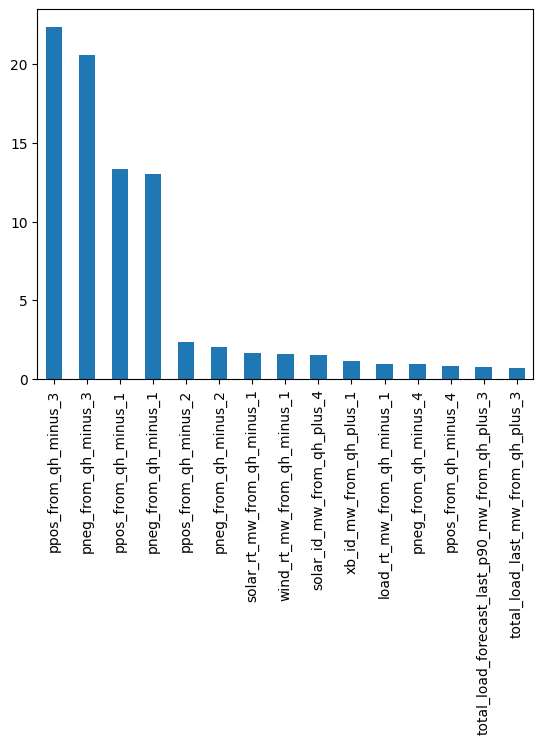

In [5]:
feature_importance = pd.DataFrame(data={"importance": 100*selector.feature_importances_}, index=FEATURES)

# Plot importance scores:
# fig, ax = plt.subplots(figsize=[15, 5])
feature_importance.importance.nlargest(15).plot(kind="bar")
# plt.ylim(0,20)
plt.show()

---

## Recursive Feature Elimination

#### Lags of system_imbalance_cum15

In [17]:
MINUTE = 3

lags = [-x for x in range(-1, 50)]
lags.remove(0)
lags.extend([1-4*24, 1-4*24+1, 1-4*24-1, 1-4*24*7, 1-4*24*7+1, 1-4*24*7-1])

qh_parameters = {
    "system_imbalance_cum15": {
        "lags": lags},
}

# Prepare training dataframe:
df = join_qh_min_data(
    qh_data=qh,
    qh_parameters=qh_parameters,
    minute_data=None,
    minute_parameters=None,
    minute=MINUTE,
)
TARGET = "system_imbalance_cum15_from_qh_plus_1"
FEATURES = [feature for feature in df.columns if feature != TARGET]

df = df.dropna()

In [18]:
# Define our selector:
selector = RandomForestRegressor(
    n_estimators=100,
    max_depth=5,
    criterion="squared_error",
    n_jobs=-1,
    verbose=False)

rfe = RFE(selector, 
    n_features_to_select=6,
    step=5,
    verbose=True) \
    .fit(df[FEATURES], df[TARGET])

Fitting estimator with 55 features.
Fitting estimator with 50 features.
Fitting estimator with 45 features.
Fitting estimator with 40 features.
Fitting estimator with 35 features.
Fitting estimator with 30 features.
Fitting estimator with 25 features.
Fitting estimator with 20 features.
Fitting estimator with 15 features.
Fitting estimator with 10 features.


In [19]:
print("Selected features:")
for ii in range(len(FEATURES)):
    if rfe.support_[ii]:
        print(FEATURES[ii])

Selected features:
system_imbalance_cum15_from_qh_minus_1
system_imbalance_cum15_from_qh_minus_2
system_imbalance_cum15_from_qh_minus_3
system_imbalance_cum15_from_qh_minus_5
system_imbalance_cum15_from_qh_minus_95
system_imbalance_cum15_from_qh_minus_671


#### Lags of minute system_imbalance

In [20]:
MINUTE = 3

qh_parameters = {
    "system_imbalance_cum15": {
        "lags": [1]},
}

lags = [-x for x in range(0, 65)]
lags.remove(0)
lags.extend([-60*2, -60*2+1, -60*2-1, -60*3, -60*3+1, -60*3-1, -60*24, -60*24+1, -60*24-1])

minute_parameters = {
    "system_imbalance": {
        "lags": lags},
}

# Prepare training dataframe:
df = join_qh_min_data(
    qh_data=qh,
    qh_parameters=qh_parameters,
    minute_data=minute,
    minute_parameters=minute_parameters,
    minute=MINUTE,
)
TARGET = "system_imbalance_cum15_from_qh_plus_1"
FEATURES = [feature for feature in df.columns if feature != TARGET]

df = df.dropna()

In [21]:
# Define our selector:
selector = RandomForestRegressor(
    n_estimators=100,
    max_depth=5,
    criterion="squared_error",
    n_jobs=-1,
    verbose=False)

rfe = RFE(selector,
    n_features_to_select=6,
    step=5,
    verbose=True) \
    .fit(df[FEATURES], df[TARGET])

Fitting estimator with 55 features.
Fitting estimator with 50 features.
Fitting estimator with 45 features.
Fitting estimator with 40 features.
Fitting estimator with 35 features.
Fitting estimator with 30 features.
Fitting estimator with 25 features.
Fitting estimator with 20 features.
Fitting estimator with 15 features.
Fitting estimator with 10 features.


In [22]:
print("Selected features:")
for ii in range(len(FEATURES)):
    if rfe.support_[ii]:
        print(FEATURES[ii])

Selected features:
system_imbalance_from_minute_minus_1
system_imbalance_from_minute_minus_4
system_imbalance_from_minute_minus_19
system_imbalance_from_minute_minus_34
system_imbalance_from_minute_minus_35
system_imbalance_from_minute_minus_36


---

## Boruta

In [18]:
from boruta import BorutaPy

selector = RandomForestRegressor(
    n_estimators=50,
    max_depth=4,
    criterion="squared_error",
    n_jobs=-1,
    verbose=False)

boruta = BorutaPy(
    estimator = selector,
    n_estimators=50,
    max_iter=100,
    random_state=1,
    verbose=True)

In [19]:
MINUTE = 3

qh_parameters = {
    "system_imbalance_cum15": {
        "lags": [1, -1, -2, -3, -5, -95, -671]},

    "total_load_last_mw": {
        "lags": [3, 2, 1, 0, -1, -2, -3, -4]},

    "nrv_rt": {
        "lags": [-1, -2, -3, -4]},
    "load_rt_mw": {
        "lags": [-1, -2, -3, -4]},
    "wind_rt_mw": {
        "lags": [-1, -2, -3, -4]},
}

minute_parameters = {
    "system_imbalance": {
        "lags": [0, -1, -4]},
    "net_regulation_volume": {
        "lags": [0, -1, -2, -3]},
}

# Prepare training dataframe:
df = join_qh_min_data(
    qh_data=qh,
    qh_parameters=qh_parameters,
    minute_data=minute,
    minute_parameters=minute_parameters,
    minute=MINUTE,
)
TARGET = "system_imbalance_cum15_from_qh_plus_1"
FEATURES = [feature for feature in df.columns if feature != TARGET]

df = df.dropna()

In [20]:
boruta.fit(df[FEATURES].values, df[TARGET].values)

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100
Iteration: 30 / 100
Iteration: 31 / 100
Iteration: 32 / 100
Iteration: 33 / 100
Iteration: 34 / 100
Iteration: 35 / 100
Iteration: 36 / 100
Iteration: 37 / 100
Iteration: 38 / 100
Iteration: 39 / 100
Iteration: 40 / 100
Iteration: 41 / 100
Iteration: 42 / 100
Iteration: 43 / 100
Iteration: 44 / 100
Iteration: 45 / 100
Iteration: 46 / 100
Iteration: 47 / 100
Iteration: 48 / 100
Iteration: 49 / 100
Iteration: 50 / 100
Iteration

BorutaPy(estimator=RandomForestRegressor(max_depth=4, n_estimators=50,
                                         n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x163941D40,
                                         verbose=False),
         n_estimators=50, random_state=RandomState(MT19937) at 0x163941D40,
         verbose=True)

In [21]:
# Important features
important = list(df[FEATURES].columns[boruta.support_])
print(f"Features confirmed as important: {important}")
# Tentative features
tentative = list(df[FEATURES].columns[boruta.support_weak_])
print(f"Unconfirmed features (tentative): {tentative}")
# Unimportant features
unimportant = list(df[FEATURES].columns[~(boruta.support_ | boruta.support_weak_)])
print(f"Features confirmed as unimportant: {unimportant}")

Features confirmed as important: ['system_imbalance_cum15_from_qh_minus_1', 'system_imbalance_cum15_from_qh_minus_2', 'system_imbalance_cum15_from_qh_minus_3', 'nrv_rt_from_qh_minus_1', 'nrv_rt_from_qh_minus_2', 'nrv_rt_from_qh_minus_3', 'system_imbalance_current_minute', 'system_imbalance_from_minute_minus_1', 'system_imbalance_from_minute_minus_4']
Unconfirmed features (tentative): ['net_regulation_volume_current_minute']
Features confirmed as unimportant: ['system_imbalance_cum15_from_qh_minus_5', 'system_imbalance_cum15_from_qh_minus_95', 'system_imbalance_cum15_from_qh_minus_671', 'total_load_last_mw_from_qh_plus_3', 'total_load_last_mw_from_qh_plus_2', 'total_load_last_mw_from_qh_plus_1', 'total_load_last_mw_current_qh', 'total_load_last_mw_from_qh_minus_1', 'total_load_last_mw_from_qh_minus_2', 'total_load_last_mw_from_qh_minus_3', 'total_load_last_mw_from_qh_minus_4', 'nrv_rt_from_qh_minus_4', 'load_rt_mw_from_qh_minus_1', 'load_rt_mw_from_qh_minus_2', 'load_rt_mw_from_qh_minus

In [22]:
important

['system_imbalance_cum15_from_qh_minus_1',
 'system_imbalance_cum15_from_qh_minus_2',
 'system_imbalance_cum15_from_qh_minus_3',
 'nrv_rt_from_qh_minus_1',
 'nrv_rt_from_qh_minus_2',
 'nrv_rt_from_qh_minus_3',
 'system_imbalance_current_minute',
 'system_imbalance_from_minute_minus_1',
 'system_imbalance_from_minute_minus_4']